In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, scipy
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as pyplot
pd.set_option('display.max_columns', 500)
# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri
import rpy2.robjects.numpy2ri
#import numpy2ri

pandas2ri.activate()
anndata2ri.activate()
rpy2.robjects.numpy2ri.activate()

%load_ext rpy2.ipython

# Herb et al., 2023 all fetal cells processing

In [2]:
%%R -o adata_fetal
library(Seurat)

sobj_ref <- readRDS('Herb_neurons/KaZhouAll.rds')
DefaultAssay(sobj_ref) <- "RNA"
adata_fetal = as.SingleCellExperiment(sobj_ref)

R[write to console]: Loading required package: SeuratObject

R[write to console]: Loading required package: sp

R[write to console]: The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.

R[write to console]: 
Attaching package: ‘SeuratObject’


R[write to console]: The following object is masked from ‘package:base’:

    intersect





    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [4]:
adata_fetal.obs = adata_fetal.obs[['Timepoint','sample','Timepoint_Study','ident']]
adata_fetal.obs = adata_fetal.obs.rename(columns={"Timepoint": "day",'sample':'reactionID', "ident": "Cell_types_2"})
adata_fetal.obs

adata_fetal.obs['diff_batch_2'] = 'Reference'
adata_fetal.obs['dimensionality'] = 'Reference'
adata_fetal.obs['source'] = 'Reference'

adata_fetal.obs
del adata_fetal.layers

In [5]:
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
        M = adata.obs[metric]
        outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
            np.median(M) + nmads * median_abs_deviation(M) < M)
        return outlier

adata_dict_unfiltered ,adata_dict_filtered = {}, {}

for batch in adata_fetal.obs.reactionID.unique():
    
    print(batch)
    
    adata_temp = adata_fetal[adata_fetal.obs.reactionID.isin([batch])].copy()
    adata_dict_unfiltered[batch] = adata_temp.copy()
    
    # mitochondrial genes
    adata_temp.var["mt"] = adata_temp.var_names.str.startswith("MT-")
    # ribosomal genes
    adata_temp.var["ribo"] = adata_temp.var_names.str.startswith(("RPS", "RPL"))
    
    sc.pp.calculate_qc_metrics(adata_temp, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True)
    
    adata_temp.obs["outlier"] = (is_outlier(adata_temp, "log1p_total_counts", 3) | is_outlier(adata_temp, "log1p_n_genes_by_counts", 3))
       
    adata_temp.obs["mt_outlier"] = is_outlier(adata_temp, "pct_counts_mt", 3.5) | (adata_temp.obs["pct_counts_mt"] > 8)
    
    print(f"Total number of cells: {adata_temp.n_obs}")
    adata_temp = adata_temp[(~adata_temp.obs.outlier) & (~adata_temp.obs.mt_outlier)].copy()
    print(f"Number of cells after filtering of low quality cells: {adata_temp.n_obs}")
    print('______________________________________________________________________')
                                 
    # Remove rare genes
    sc.pp.filter_genes(adata_temp, min_cells=3)    

    # Remove mito and ribo genes
    ribo = adata_temp.var_names.str.startswith(('RPL', "RPS"))
    mito = adata_temp.var_names.str.startswith('MT-')
    remove = np.add(mito, ribo)
    #keep = np.invert(ribo)
    
    keep = np.invert(remove)
    adata_temp = adata_temp[:,keep]
    
    adata_temp.layers["counts"] = adata_temp.X.copy()
    sc.pp.normalize_total(adata_temp, target_sum=1e4)
    sc.pp.log1p(adata_temp)
    
    adata_dict_filtered[batch] = adata_temp.copy()

CS13
Total number of cells: 3962
Number of cells after filtering of low quality cells: 3538
______________________________________________________________________
CS14
Total number of cells: 604
Number of cells after filtering of low quality cells: 556
______________________________________________________________________
CS15
Total number of cells: 2936
Number of cells after filtering of low quality cells: 2450
______________________________________________________________________
CS22_hypo
Total number of cells: 1974
Number of cells after filtering of low quality cells: 1755
______________________________________________________________________
CS22_2_hypo
Total number of cells: 1752
Number of cells after filtering of low quality cells: 1431
______________________________________________________________________
GW16_hypo
Total number of cells: 9585
Number of cells after filtering of low quality cells: 4811
______________________________________________________________________
GW18_hy

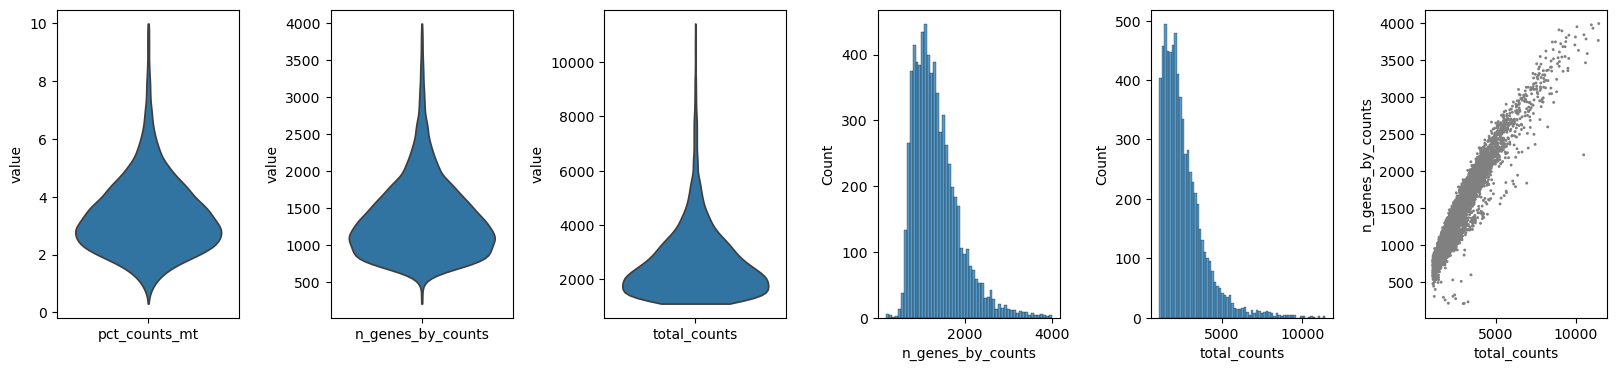

<Figure size 640x480 with 0 Axes>

In [6]:
# Check the results before and after filtering
batch = 'GW25_3V_hypo'

# Compute qc metrix
adata_dict_unfiltered[batch].var['mt'] = adata_dict_unfiltered[batch].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_dict_unfiltered[batch], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(adata_dict_unfiltered[batch],["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(adata_dict_unfiltered[batch],['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(adata_dict_unfiltered[batch],['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(adata_dict_unfiltered[batch].obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(adata_dict_unfiltered[batch].obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(adata_dict_unfiltered[batch], x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)
plt.show()
plt.clf()

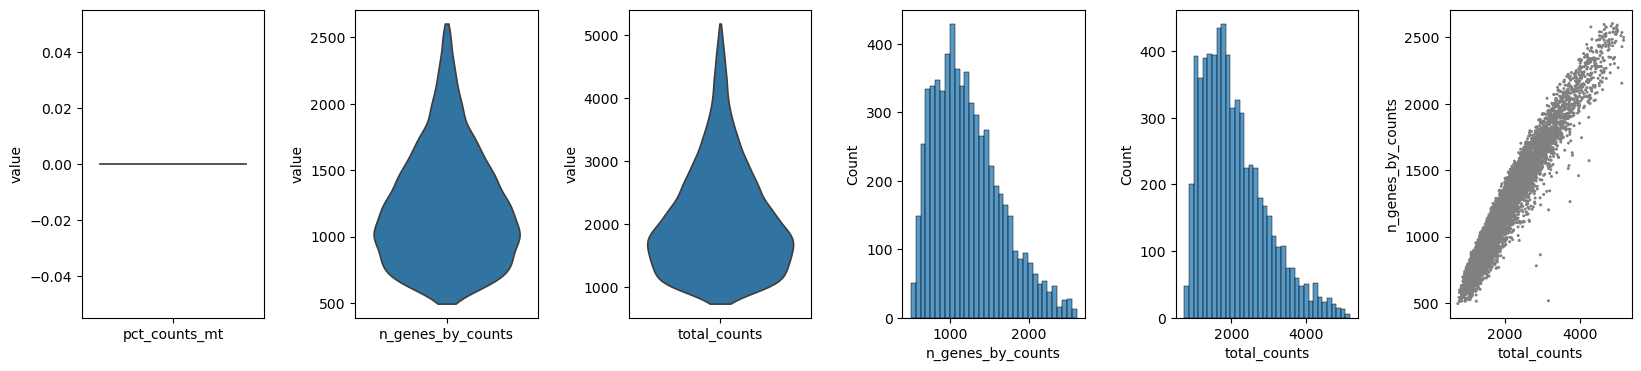

<Figure size 640x480 with 0 Axes>

In [7]:
# Compute qc metrix
adata_dict_filtered[batch].var['mt'] = adata_dict_filtered[batch].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_dict_filtered[batch], qc_vars=['mt'], layer='counts', percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(adata_dict_filtered[batch],["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(adata_dict_filtered[batch],['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(adata_dict_filtered[batch],['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(adata_dict_filtered[batch].obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(adata_dict_filtered[batch].obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(adata_dict_filtered[batch], x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)
plt.show()
plt.clf()

In [8]:
# filter adata.var and adata.obs, and concatenate the objects and save to later use
result_dict = {}

for batch, adata_temp in adata_dict_filtered.items():
    adata_temp.obs = adata_temp.obs[['day', 'reactionID', 'Timepoint_Study', 'Cell_types_2', 'diff_batch_2',
       'dimensionality', 'source']]
    del adata_temp.var
    result_dict[batch] = adata_temp.copy()
    
adata_fetal = list(result_dict.values())[0].concatenate(list(result_dict.values())[1:], batch_key=None, join='outer')
adata_fetal.var_names_make_unique()
adata_fetal.write('Data/filtered_fetal_herb_ref.h5ad')


In [9]:
adata_fetal

AnnData object with n_obs × n_vars = 130650 × 25708
    obs: 'day', 'reactionID', 'Timepoint_Study', 'Cell_types_2', 'diff_batch_2', 'dimensionality', 'source'
    layers: 'counts'

# Herb et al., 2023 neurons processing

In [3]:
%%R -o adata_ref
library(Seurat)

sobj_ref <- readRDS('Data/EdKaZhouHypoNeurons.rds')
DefaultAssay(sobj_ref) <- "RNA"
adata_ref = as.SingleCellExperiment(sobj_ref)

R[write to console]: Loading required package: SeuratObject

R[write to console]: Loading required package: sp

R[write to console]: The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.

R[write to console]: 
Attaching package: ‘SeuratObject’


R[write to console]: The following object is masked from ‘package:base’:

    intersect





    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [4]:
adata_ref.obs = adata_ref.obs[['TimepointAll','sample','AdultFetal_ExtrapolatedNuclei','H369_MarkerGenes','H369_Nuclei']]
adata_ref.obs = adata_ref.obs.rename(columns={"TimepointAll": "day",'sample':'reactionID', "AdultFetal_ExtrapolatedNuclei": "Cell_types_2"})


adata_ref.obs['diff_batch_2'] = 'Reference'
adata_ref.obs['dimensionality'] = 'Reference'
adata_ref.obs['source'] = 'Reference'

del adata_ref.layers

In [6]:
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
        M = adata.obs[metric]
        outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
            np.median(M) + nmads * median_abs_deviation(M) < M)
        return outlier

adata_dict_unfiltered ,adata_dict_filtered = {}, {}

for batch in adata_ref.obs.reactionID.unique():
    
    print(batch)
    
    adata_temp = adata_ref[adata_ref.obs.reactionID.isin([batch])].copy()
    adata_dict_unfiltered[batch] = adata_temp.copy()
    
    # mitochondrial genes
    adata_temp.var["mt"] = adata_temp.var_names.str.startswith("MT-")
    # ribosomal genes
    adata_temp.var["ribo"] = adata_temp.var_names.str.startswith(("RPS", "RPL"))
    
    sc.pp.calculate_qc_metrics(adata_temp, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True)
    
    adata_temp.obs["outlier"] = (is_outlier(adata_temp, "log1p_total_counts", 3) | is_outlier(adata_temp, "log1p_n_genes_by_counts", 4))
       
    adata_temp.obs["mt_outlier"] = is_outlier(adata_temp, "pct_counts_mt", 3.5) | (adata_temp.obs["pct_counts_mt"] > 8)
    
    print(f"Total number of cells: {adata_temp.n_obs}")
    adata_temp = adata_temp[(~adata_temp.obs.outlier) & (~adata_temp.obs.mt_outlier)].copy()
    print(f"Number of cells after filtering of low quality cells: {adata_temp.n_obs}")
    print('______________________________________________________________________')
                                 
    # Remove rare genes
    sc.pp.filter_genes(adata_temp, min_cells=3)    

    # Remove mito and ribo genes
    ribo = adata_temp.var_names.str.startswith(('RPL', "RPS"))
    mito = adata_temp.var_names.str.startswith('MT-')
    remove = np.add(mito, ribo)
    #keep = np.invert(ribo)
    
    keep = np.invert(remove)
    adata_temp = adata_temp[:,keep]
    
    adata_temp.layers["counts"] = adata_temp.X.copy()
    sc.pp.normalize_total(adata_temp, target_sum=1e4)
    sc.pp.log1p(adata_temp)
    
    adata_dict_filtered[batch] = adata_temp.copy()

CS22_hypo
Total number of cells: 1389
Number of cells after filtering of low quality cells: 1261
______________________________________________________________________
CS22_2_hypo
Total number of cells: 1010
Number of cells after filtering of low quality cells: 909
______________________________________________________________________
GW16_hypo
Total number of cells: 3136
Number of cells after filtering of low quality cells: 1428
______________________________________________________________________
GW18_hypo
Total number of cells: 2820
Number of cells after filtering of low quality cells: 2493
______________________________________________________________________
GW19_hypo
Total number of cells: 1023
Number of cells after filtering of low quality cells: 936
______________________________________________________________________
GW20_34_hypo
Total number of cells: 987
Number of cells after filtering of low quality cells: 876
______________________________________________________________

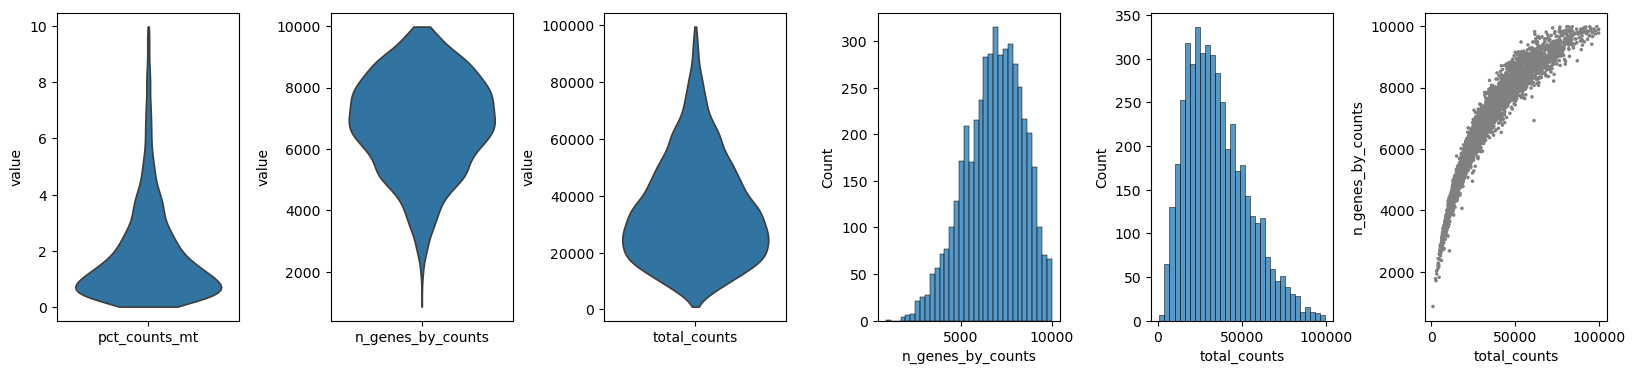

In [7]:
# Check the results before and after filtering
batch = '10X190_5'
# Compute qc metrix
adata_dict_unfiltered[batch].var['mt'] = adata_dict_unfiltered[batch].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_dict_unfiltered[batch], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(adata_dict_unfiltered[batch],["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(adata_dict_unfiltered[batch],['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(adata_dict_unfiltered[batch],['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(adata_dict_unfiltered[batch].obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(adata_dict_unfiltered[batch].obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(adata_dict_unfiltered[batch], x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

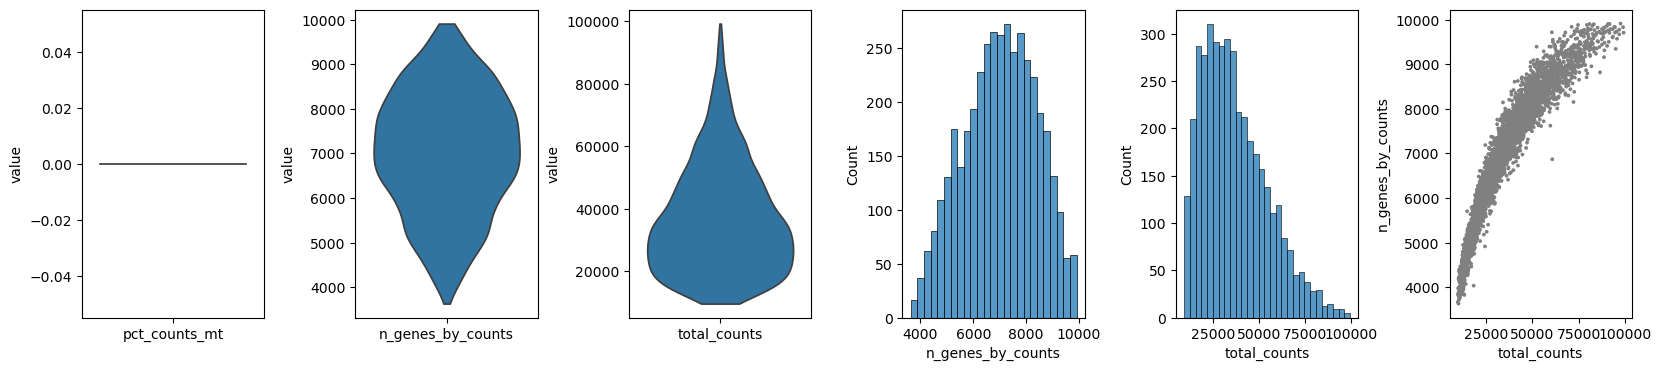

In [8]:
# Compute qc metrix
adata_dict_filtered[batch].var['mt'] = adata_dict_filtered[batch].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_dict_filtered[batch], qc_vars=['mt'], layer='counts', percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(adata_dict_filtered[batch],["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(adata_dict_filtered[batch],['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(adata_dict_filtered[batch],['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(adata_dict_filtered[batch].obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(adata_dict_filtered[batch].obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(adata_dict_filtered[batch], x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [9]:
# filter adata.var and adata.obs, and concatenate the objects and save to later use
result_dict = {}

for batch, adata_temp in adata_dict_filtered.items():
    adata_temp.obs = adata_temp.obs[['day', 'reactionID', 'Cell_types_2', 'diff_batch_2', 'dimensionality', 'source','H369_MarkerGenes','H369_Nuclei']]
    del adata_temp.var
    result_dict[batch] = adata_temp.copy()
    
adata_ref = list(result_dict.values())[0].concatenate(list(result_dict.values())[1:], batch_key=None, join='outer')
adata_ref.var_names_make_unique()

adata_ref.write('Data/filtered_herb_ref.h5ad')

In [10]:
adata_ref.var['mt'] = adata_ref.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_ref, qc_vars=['mt'], layer='counts', percent_top=None, log1p=False, inplace=True)

In [11]:
adata_ref.obs['reactionID'] = pd.Categorical(adata_ref.obs['reactionID'])

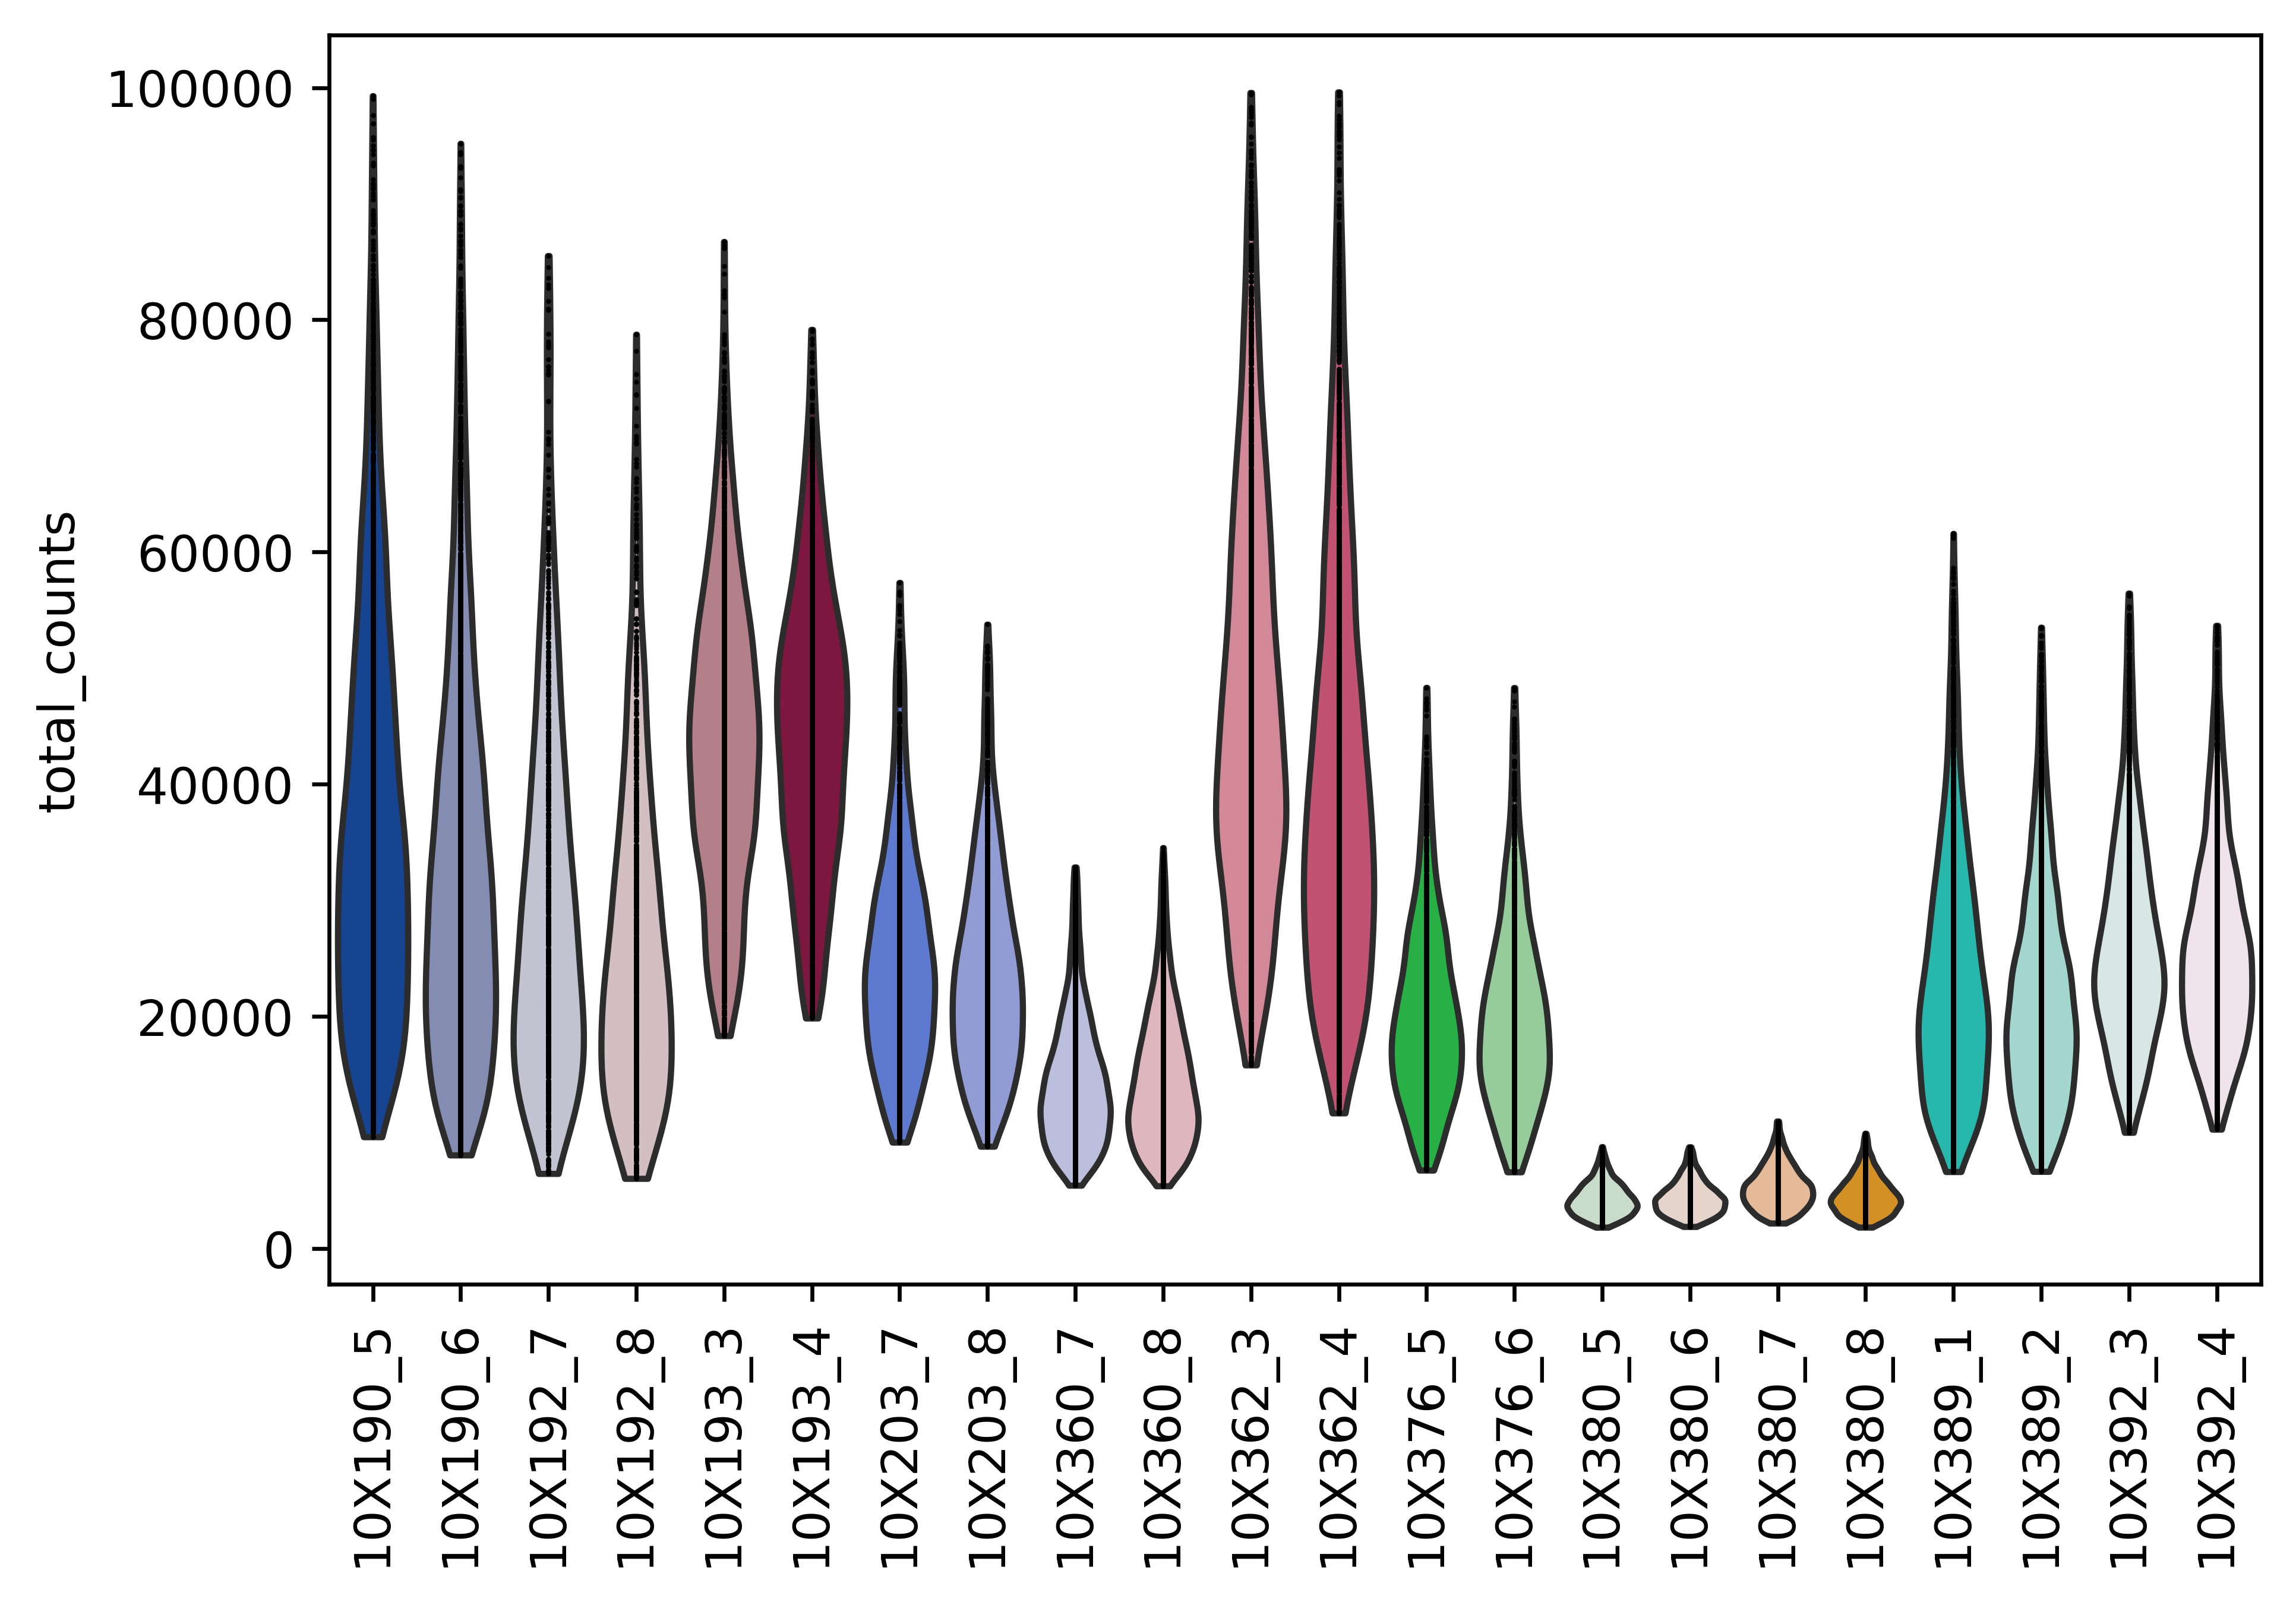

In [12]:
with plt.rc_context({ "figure.dpi": 600}):
    sc.pl.violin(adata_ref[adata_ref.obs['reactionID'].isin(['10X190_5', '10X190_6', '10X192_7', '10X192_8', '10X193_3', '10X193_4',
       '10X203_7', '10X203_8', '10X360_7', '10X360_8', '10X362_3', '10X362_4',
       '10X376_5', '10X376_6', '10X380_5', '10X380_6', '10X380_7', '10X380_8',
       '10X389_1', '10X389_2', '10X392_3', '10X392_4'])], 'total_counts',
             jitter=False, groupby = 'reactionID', rotation= 90)

# Merge the filtered datasets

In [21]:
adata_neurons = sc.read('Data/filtered_herb_ref.h5ad')
adata_fetal = sc.read('Data/filtered_fetal_herb_ref.h5ad')

In [22]:
adata_neurons.obs = adata_neurons.obs[['day','reactionID','Cell_types_2','diff_batch_2','dimensionality','source']]

In [23]:
adata_neurons

AnnData object with n_obs × n_vars = 102557 × 43445
    obs: 'day', 'reactionID', 'Cell_types_2', 'diff_batch_2', 'dimensionality', 'source'
    layers: 'counts'

In [24]:
cells = list(set([i[:i.rfind('-')] for i in adata_fetal.obs_names])-set([i[:i.rindex('-')] for i in adata_neurons.obs_names]))
adata_fetal.obs_names = [i[:i.rfind('-')] for i in adata_fetal.obs_names]
len(cells)

101249

In [25]:
adata_fetal_non_neurons = adata_fetal[cells,:][adata_fetal[cells,:].obs.Cell_types_2.isin(['Astrocytes', 'Blood', 'Endothelial', 'Ependymal', 'IntProgen_1', 'Microglia',
       'Oligodendrocytes [Dividing]', 'Oligodendrocytes [Immature]',
       'Oligodendrocytes [Intermediate]', 'Oligodendrocytes [Mature]',
       'Pericytes', 'Tanycytes', 'VLMC', 'cRGC', 'qRGC', 'tRGC', 'vSMC'])]

adata_merged = adata_fetal_non_neurons.concatenate(adata_neurons, batch_key=None, join='inner')

In [87]:
adata_merged.write('Data/herb_hypo_ref.h5ad')